# Survival Analysis of Churn

In [1]:
options(repr.plot.width = 5, repr.plot.height = 4, warn = FALSE)
library(tidyverse)
library(survival)
library(rpart)
# library(grid)

Warning message:
"package 'tidyverse' was built under R version 3.4.4"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.4
v tidyr   0.8.0     v stringr 1.3.0
v readr   1.1.1     v forcats 0.3.0
Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'tibble' was built under R version 3.4.4"Warning message:
"package 'tidyr' was built under R version 3.4.4"Warning message:
"package 'readr' was built under R version 3.4.4"Warning message:
"package 'purrr' was built under R version 3.4.4"Warning message:
"package 'stringr' was built under R version 3.4.4"Warning message:
"package 'forcats' was built under R version 3.4.4"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'survival' was built under R version 3.4.4"Warning m

In [2]:
data <- read_csv('data/data.csv') %>% 
    mutate(white_label = white_label == 'True',
           zapier = zapier == 'True'
          )  %>% 
    filter(time >= 0) 
data %>% head()

Parsed with column specification:
cols(
  .default = col_double(),
  tenant_id = col_integer(),
  status = col_integer(),
  time = col_integer(),
  life = col_integer(),
  end_date = col_datetime(format = ""),
  lead_type = col_character(),
  custom_email = col_integer(),
  funnel = col_character(),
  white_label = col_character(),
  question_bank = col_character(),
  zapier = col_character(),
  infusionsoft = col_character(),
  disqus = col_character(),
  analytics = col_character(),
  mail_int = col_character()
)
See spec(...) for full column specifications.
Warning message:
"package 'bindrcpp' was built under R version 3.4.4"

tenant_id,status,time,life,end_date,lead_type,custom_email,funnel,nb_enrol,enrol_3m,...,zapier,infusionsoft,disqus,analytics,mail_int,free_trial,tickets,ticket_3m,active,active_3m
700,0,1235,1406,2018-10-01 00:00:00,Starter,1,missing,1999,0.02197802,...,FALSE,False,False,True,False,0,37,0.00000000,0.09601707,0.01098901
1568,0,1274,1275,2018-10-01 00:00:00,Starter,1,missing,25,0.01098901,...,FALSE,False,False,False,False,0,0,0.00000000,0.04705882,0.09890110
76861,0,398,425,2018-10-01 00:00:00,Starter,1,3A-3B,119,0.01098901,...,FALSE,False,True,True,False,1,13,0.00000000,0.12470588,0.02197802
191,0,1305,1539,2018-10-01 00:00:00,Starter,1,missing,5131,2.37362637,...,TRUE,False,False,True,False,0,29,0.02197802,0.14165042,0.18681319
1182,0,1311,1321,2018-10-01 00:00:00,Starter,0,missing,2,0.00000000,...,FALSE,False,False,False,False,0,0,0.00000000,0.00000000,0.00000000
1213,1,670,752,2017-03-14 13:42:47,Starter,1,missing,158,0.02197802,...,FALSE,False,True,False,False,0,0,0.00000000,0.00000000,0.00000000


## EDA

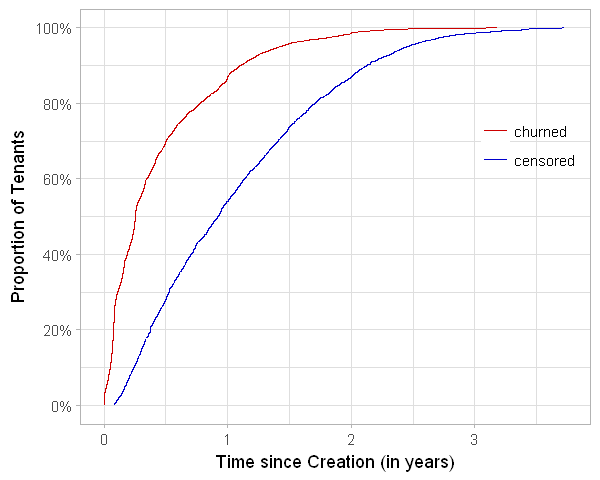

In [3]:
# CDF
data <- data %>% 
    arrange(time) %>% 
    group_by(status) %>% 
    mutate(rank = row_number()/n())

colours <- c('blue3', 'red3')
names(colours) <- c('censored', 'churned')
ggplot(data = NULL) +
    geom_line(aes(data$time[data$status == 1], data$rank[data$status == 1], colour = 'churned')) +
    geom_line(aes(data$time[data$status == 0], data$rank[data$status == 0], colour = 'censored')) +
    
#     geom_hline(aes(yintercept = max(data$rank[data$time <= 7])), colour = 'red') +
#     annotate('text', x = 1370, y = max(data$rank[data$time <= 7]) + .025, colour = 'red', size = 3, hjust = 1,
#              label = paste('one week: ', as.character(round(max(data$rank[data$time <= 7])*100)), '%', sep = '')) +
    
#     geom_hline(aes(yintercept = max(data$rank[data$time <= 30])), colour = 'orangered') +
#     annotate('text', x = 1370, y = max(data$rank[data$time <= 30]) + .025, colour = 'orangered', size = 3, hjust = 1,
#              label = paste('one month: ', as.character(round(max(data$rank[data$time <= 30])*100)), '%', sep = '')) +
    
#     geom_hline(aes(yintercept = max(data$rank[data$time <= 91])), colour = 'darkorange') +
#     annotate('text', x = 1370, y = max(data$rank[data$time <= 91]) + .025, colour = 'darkorange', size = 3, hjust = 1,
#              label = paste('three months: ', as.character(round(max(data$rank[data$time <= 91])*100)), '%', sep = '')) +
    
#     geom_hline(aes(yintercept = max(data$rank[data$time <= 365])), colour = 'orange') +
#     annotate('text', x = 1370, y = max(data$rank[data$time <= 365]) + .025, colour = 'orange', size = 3, hjust = 1,
#              label = paste('one year: ', as.character(round(max(data$rank[data$time <= 365])*100)), '%', sep = '')) +

    scale_y_continuous("Proportion of Tenants", labels = scales::percent, breaks = c(0, .2, .4, .6, .8, 1)) + 
    scale_colour_manual("", values = colours, breaks = c('churned', 'censored')) +
    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75), 
                       labels = c('0', '1', '2', '3'), limits = c(0, 1370)) + 
    theme_light()+ theme(legend.position = c(.88,.7), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/time_dist.png', height = 4, width = 6)

In [4]:
n <- length(data$status)
sub <- data %>% filter(status == 1)
m <- length(sub$status)

print(paste('Number of tenants:', n))
print(paste('Number of subscriptions:', m))
print(paste('Proportion of tenants subscribing:', m/n*100))
print(paste("In the first day:       ", as.character(sum(sub$time <= 1)), "  ", as.character(sum(sub$time <= 1)/m*100)))
print(paste("In the first week:      ", as.character(sum(sub$time <= 7)), "  ", as.character(sum(sub$time <= 7)/m*100)))
print(paste("In the first two weeks: ", as.character(sum(sub$time <= 14)), "  ", as.character(sum(sub$time <= 14)/m*100)))
print(paste("In the first month:     ", as.character(sum(sub$time <= 30.5)), "  ", as.character(sum(sub$time <= 30.5)/m*100)))
print(paste("In the first quarter:   ", as.character(sum(sub$time <= 91.5)), " ", as.character(sum(sub$time <= 91.5)/m*100)))
print(paste("In the first 6 months:  ", as.character(sum(sub$time <= 183)), " ", as.character(sum(sub$time <= 183)/m*100)))
print(paste("In the first year:      ", as.character(sum(sub$time <= 365)), " ", as.character(sum(sub$time <= 365)/m*100)))
print(paste("After two years:        ", as.character(sum(sub$time > 730)), "    ", as.character(sum(sub$time > 730)/m*100)))

[1] "Number of tenants: 12392"
[1] "Number of subscriptions: 6718"
[1] "Proportion of tenants subscribing: 54.2123950936088"
[1] "In the first day:        185    2.75379577255135"
[1] "In the first week:       340    5.06103006847276"
[1] "In the first two weeks:  544    8.09764810955642"
[1] "In the first month:      1580    23.518904435844"
[1] "In the first quarter:    3279   48.8091693956535"
[1] "In the first 6 months:   4691   69.8273295623698"
[1] "In the first year:       5840   86.9306341172968"
[1] "After two years:         94      1.39922596010717"


In [5]:
print(paste("After 3 months:      ", as.character(sum(data$time > 91.5)), "    ", as.character(sum(data$time > 91.5)/(sum(data$time > 91.5)+sum(sub$time <= 91.5))*100)))
print(paste("After a year:        ", as.character(sum(data$time > 365)), "    ", as.character(sum(data$time > 365)/(sum(data$time > 365)+sum(sub$time <= 365))*100)))

[1] "After 3 months:       8509      72.1835765184934"
[1] "After a year:         3488      37.3927958833619"


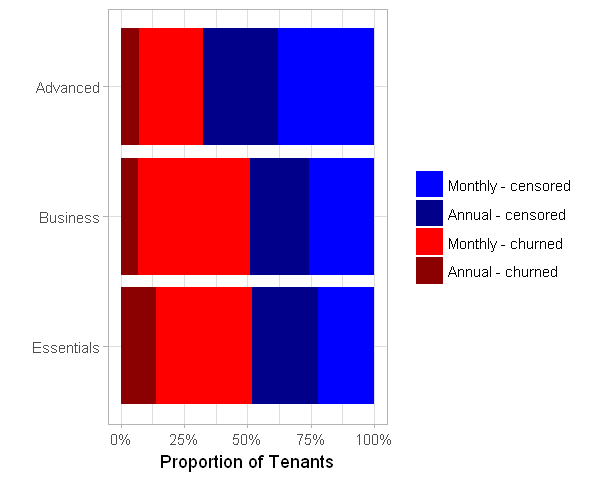

In [6]:
props <- data_frame('plan' = c('Advanced', 'Business', 'Essentials', 'Advanced', 'Business', 'Essentials', 'Advanced', 'Business', 'Essentials', 'Advanced', 'Business', 'Essentials'),
                    'level' = c('Monthly - churned', 'Monthly - churned', 'Monthly - churned', 'Monthly - censored', 'Monthly - censored', 'Monthly - censored', 'Annual - churned', 'Annual - churned', 'Annual - churned', 'Annual - censored', 'Annual - censored', 'Annual - censored'),
                    'churn' = c('Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No'),
                    'tenants' = c(.252, .441, .378, .378, .259, .222, .074, .069, .14, .296, .231, .26)
                    )  

props$plan <- factor(props$plan, levels = c('Essentials', 'Business', 'Advanced'))
props$level <- factor(props$level, levels = c('Monthly - censored', 'Annual - censored', 'Monthly - churned', 'Annual - churned'))

colours <- c('red4', 'red1', 'blue4', 'blue1')
names(colours) <- c('Annual - churned', 'Monthly - churned', 'Annual - censored', 'Monthly - censored')
ggplot(props, aes(plan, weight = tenants, fill = level)) +
    geom_bar(position = 'fill') + coord_flip() +
    scale_y_continuous("Proportion of Tenants", labels = scales::percent) + 
    scale_fill_manual("", values = colours) + xlab('') +
    theme_light() 

ggsave('img/plan_dist.png', height = 3, width = 5)

In [7]:
print(paste('none:           ', sum((data$coupons==0) & (data$groups==0) & !(data$drip_schedule>0) & !(data$bundles>0) & !(data$private_hidden>0) & !data$white_label & !(data$certificates>0) & !data$zapier), sum((data$coupons==0) & (data$groups==0) & !(data$drip_schedule>0) & !(data$bundles>0) & !(data$private_hidden>0) & !data$white_label & !(data$certificates>0) & !data$zapier)/n, sum((sub$coupons==0) & (sub$groups==0) & !(sub$drip_schedule>0) & !(sub$bundles>0) & !(sub$private_hidden>0) & !sub$white_label & !(sub$certificates>0) & !sub$zapier)/sum((data$coupons==0) & (data$groups==0) & !(data$drip_schedule>0) & !(data$bundles>0) & !(data$private_hidden>0) & !data$white_label & !(data$certificates>0) & !data$zapier), sum((sub$coupons==0) & (sub$groups==0) & !(sub$drip_schedule>0) & !(sub$bundles>0) & !(sub$private_hidden>0) & !sub$white_label & !(sub$certificates>0) & !sub$zapier)/m))
print(paste('coupons:        ', sum(data$coupons>0),        sum(data$coupons>0)       /n, sum(sub$coupons>0)       /sum(data$coupons>0),        sum(sub$coupons>0)       /m))
print(paste('groups:         ', sum(data$groups>0),         sum(data$groups>0)        /n, sum(sub$groups>0)        /sum(data$groups>0),         sum(sub$groups>0)        /m))
print(paste('drip schedule:  ', sum(data$drip_schedule>0),  sum(data$drip_schedule>0) /n, sum(sub$drip_schedule>0) /sum(data$drip_schedule>0),  sum(sub$drip_schedule>0) /m))
print(paste('bundles:        ', sum(data$bundles>0),        sum(data$bundles>0)       /n, sum(sub$bundles>0)       /sum(data$bundles>0),        sum(sub$bundles>0)       /m))
print(paste('private/hidden: ', sum(data$private_hidden>0), sum(data$private_hidden>0)/n, sum(sub$private_hidden>0)/sum(data$private_hidden>0), sum(sub$private_hidden>0)/m))
print(paste('white label:    ', sum(data$white_label),      sum(data$white_label)     /n, sum(sub$white_label)     /sum(data$white_label),      sum(sub$white_label)     /m))
print(paste('certificates:   ', sum(data$certificates>0),   sum(data$certificates>0)  /n, sum(sub$certificates>0)  /sum(data$certificates>0),   sum(sub$certificates>0)  /m))
print(paste('zapier:         ', sum(data$zapier),           sum(data$zapier)          /n, sum(sub$zapier)          /sum(data$zapier),           sum(sub$zapier)          /m))
print(paste('free trial:     ', sum(data$free_trial>0),     sum(data$free_trial>0)    /n, sum(sub$free_trial>0)    /sum(data$free_trial>0),     sum(sub$free_trial>0)    /m))

[1] "none:            3518 0.283892834086507 0.806424104604889 0.422298303066389"
[1] "coupons:         5543 0.447304712717883 0.398881472127007 0.329115808276273"
[1] "groups:          1583 0.127743705616527 0.146557169930512 0.0345340875260494"
[1] "drip schedule:   3365 0.271546158812137 0.42109955423477 0.210925870794879"
[1] "bundles:         3746 0.30229180116204 0.392685531233316 0.218963977374219"
[1] "private/hidden:  3835 0.309473854099419 0.311864406779661 0.178029175349807"
[1] "white label:     4773 0.385167850225952 0.363084014246805 0.257963679666567"
[1] "certificates:    1698 0.137023886378309 0.210836277974087 0.0532896695445073"
[1] "zapier:          995 0.0802937378954164 0.264321608040201 0.0391485561178922"
[1] "free trial:      3640 0.293737895416398 0.743681318681319 0.402947305745758"


## Bivariate Survival Stuff

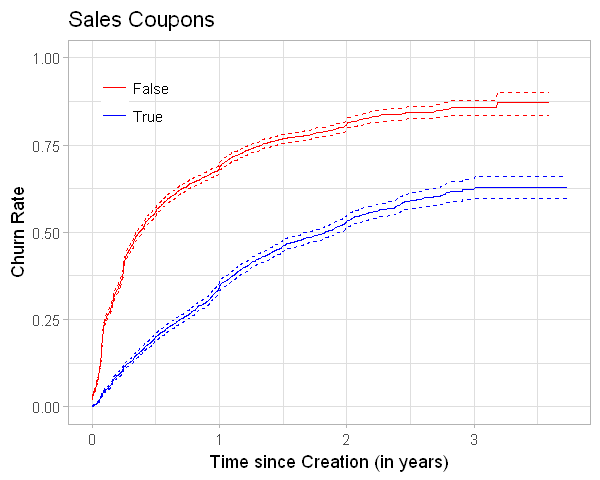

In [8]:
surv.email <- survfit(Surv(time, status == 1) ~ coupons>0, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("Sales Coupons") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_coupon.png', height = 3, width = 4)

In [9]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.6849986 0.3448807

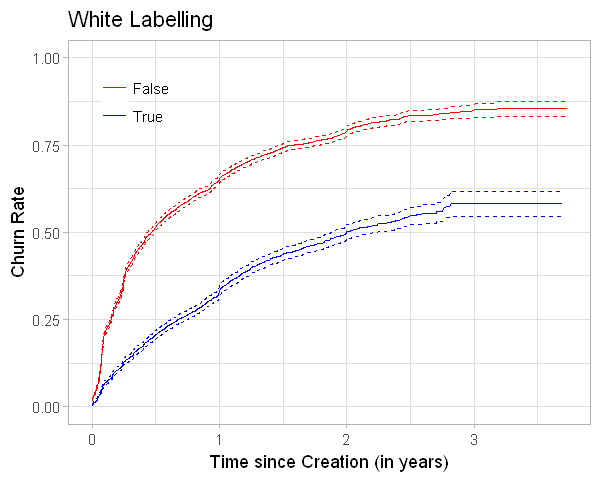

In [10]:
surv.email <- survfit(Surv(time, status == 1) ~ white_label, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("White Labelling") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_wl.png', height = 3, width = 4)

In [11]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.6527605 0.3313565

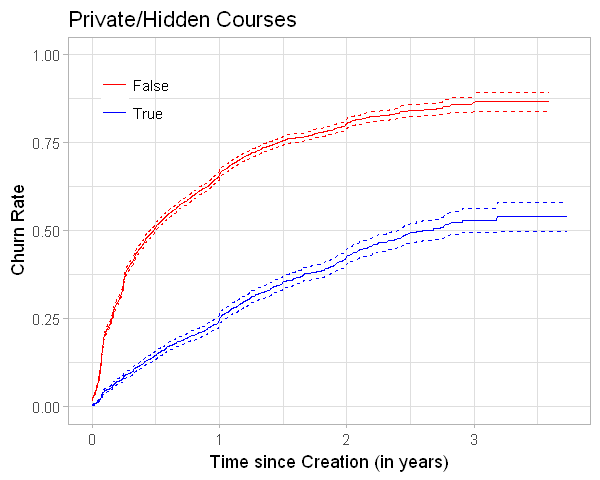

In [12]:
surv.email <- survfit(Surv(time, status == 1) ~ private_hidden>0, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("Private/Hidden Courses") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_priv.png', height = 3, width = 4)

In [13]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.6599180 0.2485155

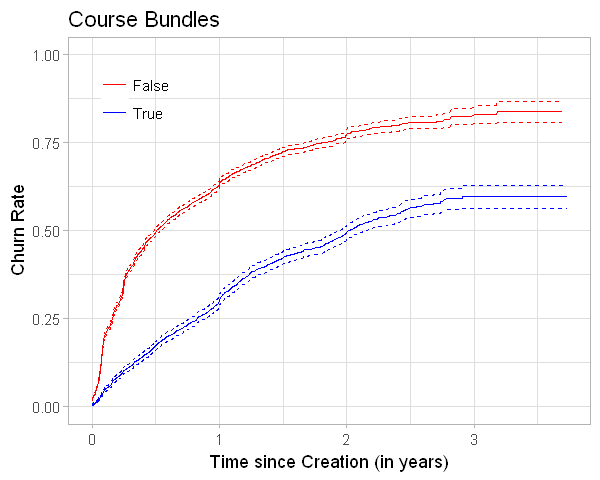

In [14]:
surv.email <- survfit(Surv(time, status == 1) ~ bundles>0, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("Course Bundles") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_bundle.png', height = 3, width = 4)

In [15]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.6343363 0.3027631

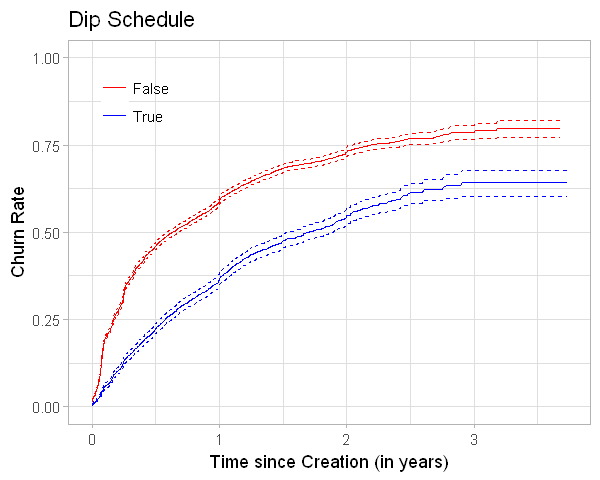

In [16]:
surv.email <- survfit(Surv(time, status == 1) ~ drip_schedule>0, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("Dip Schedule") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_ds.png', height = 3, width = 4)

In [17]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.5906114 0.3670250

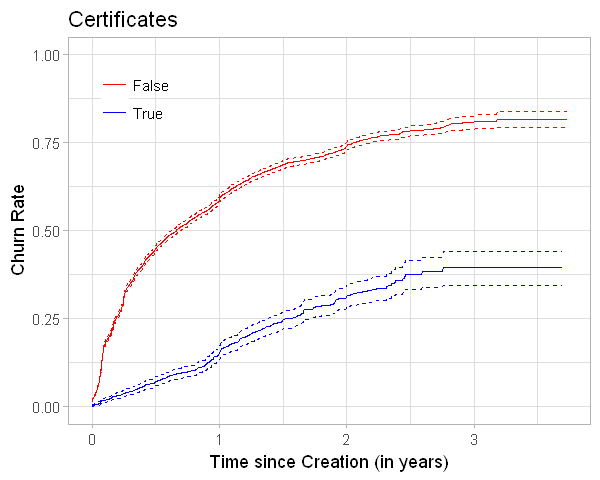

In [18]:
surv.email <- survfit(Surv(time, status == 1) ~ certificates>0, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("Certificates") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_certif.png', height = 3, width = 4)

In [19]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.5901053 0.1529291

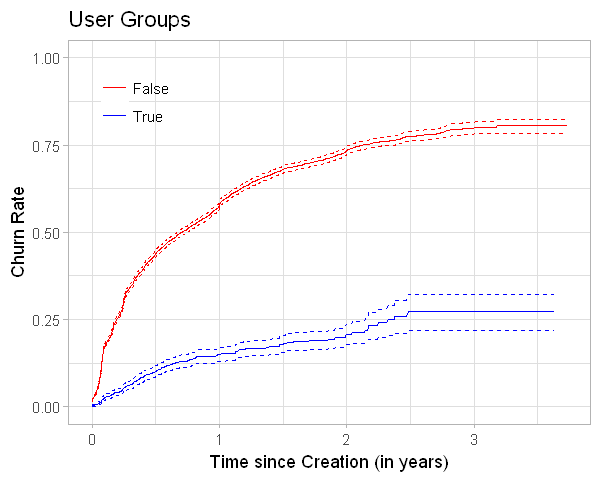

In [20]:
surv.email <- survfit(Surv(time, status == 1) ~ groups>0, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("User Groups") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_group.png', height = 3, width = 4)

In [21]:
1 - surv.email$surv[surv.email$time == 366]

[1] 0.5822490 0.1499112

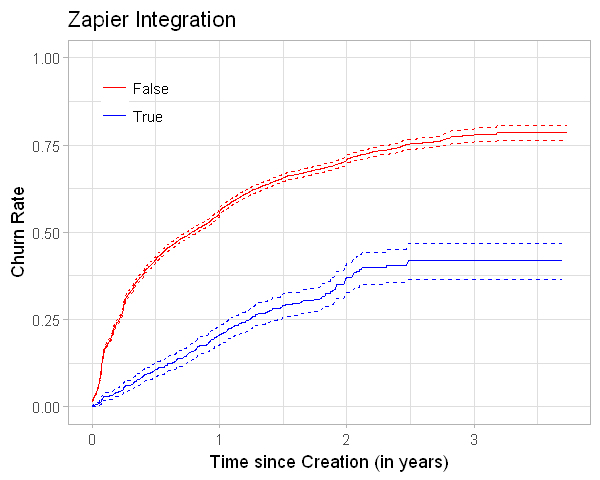

In [22]:
surv.email <- survfit(Surv(time, status == 1) ~ zapier, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("Zapier Integration") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_zapier.png', height = 3, width = 4)

In [23]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.5584391 0.2057844

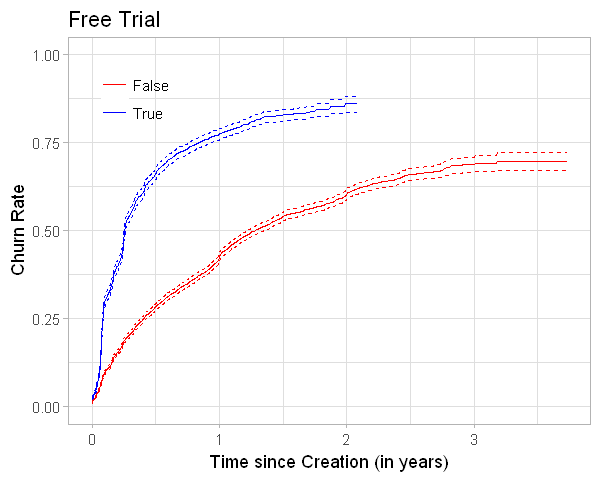

In [24]:
surv.email <- survfit(Surv(time, status == 1) ~ free_trial>0, data = data)

# Plot 
colours <- c('blue', 'red')
names(colours) <- c('True', 'False')
ggplot(data = NULL) +
    # For the first group: False - no payment integration
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$lower[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$upper[1:surv.email$strata[1]]), 
              lty = 2, colour = 'red') +
    geom_line(aes(surv.email$time[1:surv.email$strata[1]], 1 - surv.email$surv[1:surv.email$strata[1]], 
                 colour = 'False')) +

    # For the second group: True - with payment integration
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$lower[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$upper[(surv.email$strata[1]+1):length(surv.email$surv)]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(surv.email$time[(surv.email$strata[1]+1):length(surv.email$surv)], 1 - surv.email$surv[(surv.email$strata[1]+1):length(surv.email$surv)], 
                 colour = 'True')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours) +
    ggtitle("Free Trial") +
    theme_light() + theme(legend.position = c(.13,.87), legend.background = element_rect(fill="transparent",colour=NA))

ggsave('img/km_promo.png', height = 3, width = 4)

In [25]:
1 - surv.email$surv[surv.email$time == 365]

[1] 0.4254830 0.7736815

In [26]:
summary(coxph(Surv(time, status == 1) ~ coupons==0, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ coupons == 0, data = data)

  n= 12392, number of events= 6718 

                   coef exp(coef) se(coef)     z Pr(>|z|)    
coupons == 0TRUE 1.0457    2.8453   0.0264 39.62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                 exp(coef) exp(-coef) lower .95 upper .95
coupons == 0TRUE     2.845     0.3515     2.702     2.996

Concordance= 0.641  (se = 0.003 )
Rsquare= 0.128   (max possible= 1 )
Likelihood ratio test= 1691  on 1 df,   p=<2e-16
Wald test            = 1569  on 1 df,   p=<2e-16
Score (logrank) test = 1703  on 1 df,   p=<2e-16


In [27]:
summary(coxph(Surv(time, status == 1) ~ !white_label, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ !white_label, data = data)

  n= 12392, number of events= 6718 

                    coef exp(coef) se(coef)     z Pr(>|z|)    
!white_labelTRUE 0.96072   2.61357  0.02805 34.25   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                 exp(coef) exp(-coef) lower .95 upper .95
!white_labelTRUE     2.614     0.3826     2.474     2.761

Concordance= 0.615  (se = 0.003 )
Rsquare= 0.102   (max possible= 1 )
Likelihood ratio test= 1326  on 1 df,   p=<2e-16
Wald test            = 1173  on 1 df,   p=<2e-16
Score (logrank) test = 1262  on 1 df,   p=<2e-16


In [28]:
summary(coxph(Surv(time, status == 1) ~ private_hidden==0, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ private_hidden == 0, 
    data = data)

  n= 12392, number of events= 6718 

                           coef exp(coef) se(coef)     z Pr(>|z|)    
private_hidden == 0TRUE 1.24899   3.48682  0.03234 38.63   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                        exp(coef) exp(-coef) lower .95 upper .95
private_hidden == 0TRUE     3.487     0.2868     3.273     3.715

Concordance= 0.625  (se = 0.003 )
Rsquare= 0.14   (max possible= 1 )
Likelihood ratio test= 1865  on 1 df,   p=<2e-16
Wald test            = 1492  on 1 df,   p=<2e-16
Score (logrank) test = 1677  on 1 df,   p=<2e-16


In [29]:
summary(coxph(Surv(time, status == 1) ~ bundles==0, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ bundles == 0, data = data)

  n= 12392, number of events= 6718 

                    coef exp(coef) se(coef)     z Pr(>|z|)    
bundles == 0TRUE 0.96269   2.61873  0.03002 32.07   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                 exp(coef) exp(-coef) lower .95 upper .95
bundles == 0TRUE     2.619     0.3819     2.469     2.777

Concordance= 0.607  (se = 0.003 )
Rsquare= 0.092   (max possible= 1 )
Likelihood ratio test= 1192  on 1 df,   p=<2e-16
Wald test            = 1029  on 1 df,   p=<2e-16
Score (logrank) test = 1102  on 1 df,   p=<2e-16


In [30]:
summary(coxph(Surv(time, status == 1) ~ drip_schedule==0, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ drip_schedule == 0, 
    data = data)

  n= 12392, number of events= 6718 

                          coef exp(coef) se(coef)     z Pr(>|z|)    
drip_schedule == 0TRUE 0.66722   1.94881  0.03004 22.21   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                       exp(coef) exp(-coef) lower .95 upper .95
drip_schedule == 0TRUE     1.949     0.5131     1.837     2.067

Concordance= 0.575  (se = 0.003 )
Rsquare= 0.044   (max possible= 1 )
Likelihood ratio test= 553.9  on 1 df,   p=<2e-16
Wald test            = 493.2  on 1 df,   p=<2e-16
Score (logrank) test = 511.3  on 1 df,   p=<2e-16


In [31]:
summary(coxph(Surv(time, status == 1) ~ certificates==0, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ certificates == 0, 
    data = data)

  n= 12392, number of events= 6718 

                         coef exp(coef) se(coef)     z Pr(>|z|)    
certificates == 0TRUE 1.50481   4.50331  0.05449 27.62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                      exp(coef) exp(-coef) lower .95 upper .95
certificates == 0TRUE     4.503     0.2221     4.047     5.011

Concordance= 0.572  (se = 0.002 )
Rsquare= 0.093   (max possible= 1 )
Likelihood ratio test= 1205  on 1 df,   p=<2e-16
Wald test            = 762.8  on 1 df,   p=<2e-16
Score (logrank) test = 915.2  on 1 df,   p=<2e-16


In [32]:
summary(coxph(Surv(time, status == 1) ~ groups==0, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ groups == 0, data = data)

  n= 12392, number of events= 6718 

                   coef exp(coef) se(coef)     z Pr(>|z|)    
groups == 0TRUE 1.70121   5.48060  0.06684 25.45   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                exp(coef) exp(-coef) lower .95 upper .95
groups == 0TRUE     5.481     0.1825     4.808     6.248

Concordance= 0.562  (se = 0.002 )
Rsquare= 0.088   (max possible= 1 )
Likelihood ratio test= 1141  on 1 df,   p=<2e-16
Wald test            = 647.7  on 1 df,   p=<2e-16
Score (logrank) test = 819.5  on 1 df,   p=<2e-16


In [33]:
summary(coxph(Surv(time, status == 1) ~ !zapier, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ !zapier, data = data)

  n= 12392, number of events= 6718 

               coef exp(coef) se(coef)     z Pr(>|z|)    
!zapierTRUE 1.18665   3.27610  0.06302 18.83   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

            exp(coef) exp(-coef) lower .95 upper .95
!zapierTRUE     3.276     0.3052     2.895     3.707

Concordance= 0.539  (se = 0.002 )
Rsquare= 0.041   (max possible= 1 )
Likelihood ratio test= 518.9  on 1 df,   p=<2e-16
Wald test            = 354.6  on 1 df,   p=<2e-16
Score (logrank) test = 398  on 1 df,   p=<2e-16


In [34]:
summary(coxph(Surv(time, status == 1) ~ free_trial>0, data=data))

Call:
coxph(formula = Surv(time, status == 1) ~ free_trial > 0, data = data)

  n= 12392, number of events= 6718 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
free_trial > 0TRUE 1.03377   2.81165  0.02555 40.45   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                   exp(coef) exp(-coef) lower .95 upper .95
free_trial > 0TRUE     2.812     0.3557     2.674     2.956

Concordance= 0.619  (se = 0.003 )
Rsquare= 0.114   (max possible= 1 )
Likelihood ratio test= 1497  on 1 df,   p=<2e-16
Wald test            = 1636  on 1 df,   p=<2e-16
Score (logrank) test = 1776  on 1 df,   p=<2e-16


## Survival Tree

In [35]:
# Pass a survival object from Surv() to the function rpart()
fit <- rpart(Surv(time, status == 1) ~ nb_enrol + revenue + payment_options + custom_email + 
                                    funnel + lead_type + coupons + drip_schedule + zapier + bundles + 
                                    certificates + white_label + private_hidden + groups + free_trial,
             data = data %>% mutate(time = time + 1), cp = -1)

In [36]:
fit$variable.importance

nb_enrol         revenue         coupons payment_options  private_hidden 
     5722.14342      3112.32375      2573.33911      2208.54687      2033.65447 
        bundles          funnel   drip_schedule    certificates          groups 
     1889.30561       427.39362       300.91410       277.81001       248.83707 
     free_trial     white_label       lead_type    custom_email          zapier 
      240.53877       224.83556       181.15729       127.74601        46.84131

In [37]:
# Print details of the tree
fit <- prune(fit, cp=.002)
print(fit)

n= 12392 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 12392 18210.9200 1.00000000  
   2) nb_enrol>=11.5 6194  6114.1450 0.44359730  
     4) nb_enrol>=85.5 3280  2494.4340 0.24137800  
       8) nb_enrol>=547 1327   725.1913 0.12527930  
        16) groups>=0.5 438   103.9573 0.03790094 *
        17) groups< 0.5 889   575.4523 0.16736550 *
       9) nb_enrol< 547 1953  1633.1810 0.33830520  
        18) groups>=0.5 492   257.2169 0.13949700 *
        19) groups< 0.5 1461  1309.7830 0.40016950  
          38) revenue>=2388.882 572   434.7074 0.27033660 *
          39) revenue< 2388.882 889   837.9171 0.49572870 *
     5) nb_enrol< 85.5 2914  3003.0830 0.74950070  
      10) groups>=0.5 474   390.0415 0.33043180 *
      11) groups< 0.5 2440  2515.7180 0.82807630  
        22) revenue>=1092.241 522   450.5629 0.48911460 *
        23) revenue< 1092.241 1918  1989.2000 0.93637880  
          46) certificates>=1.5 213   192.6335 0.51916450 *
          47) certif

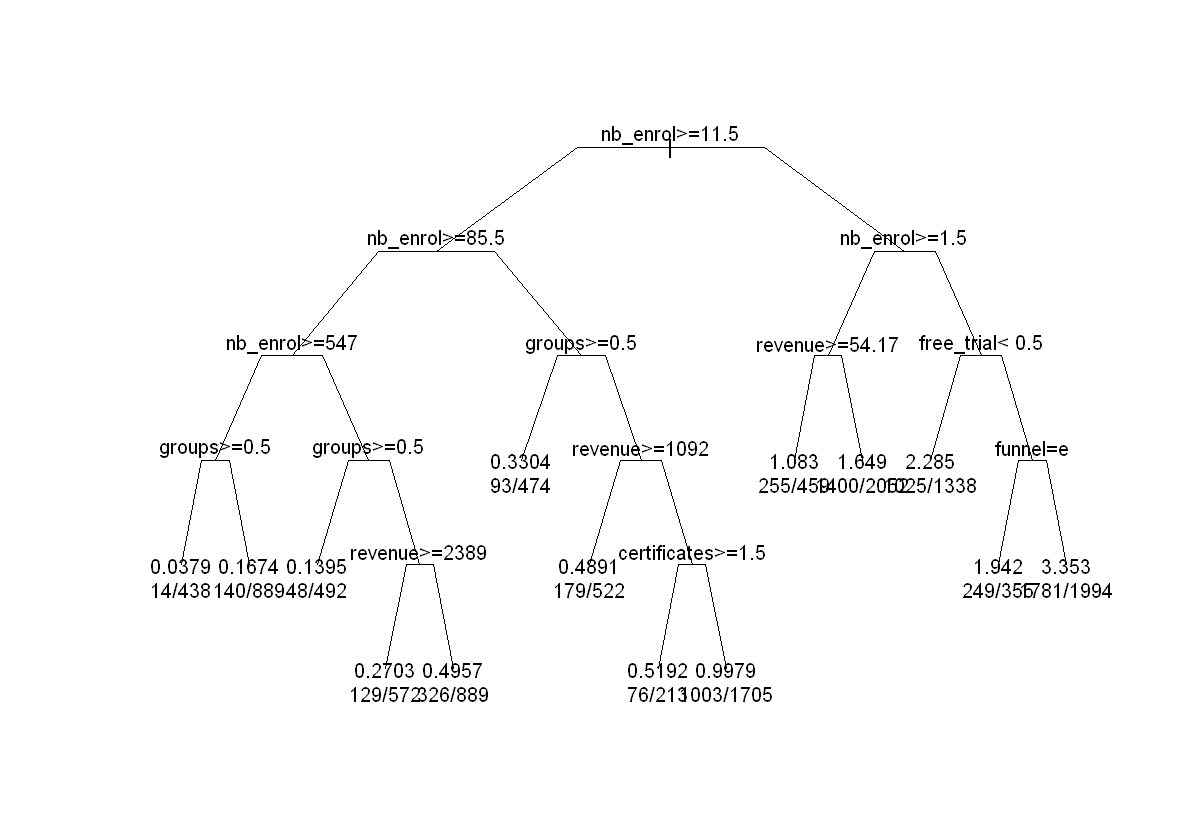

In [38]:
# Plot the resulting tree
options(repr.plot.width = 10, repr.plot.height = 7, warn = FALSE)

plot(fit, uniform = T, branch = .4, margin = 0.05)
text(fit, use.n = T)

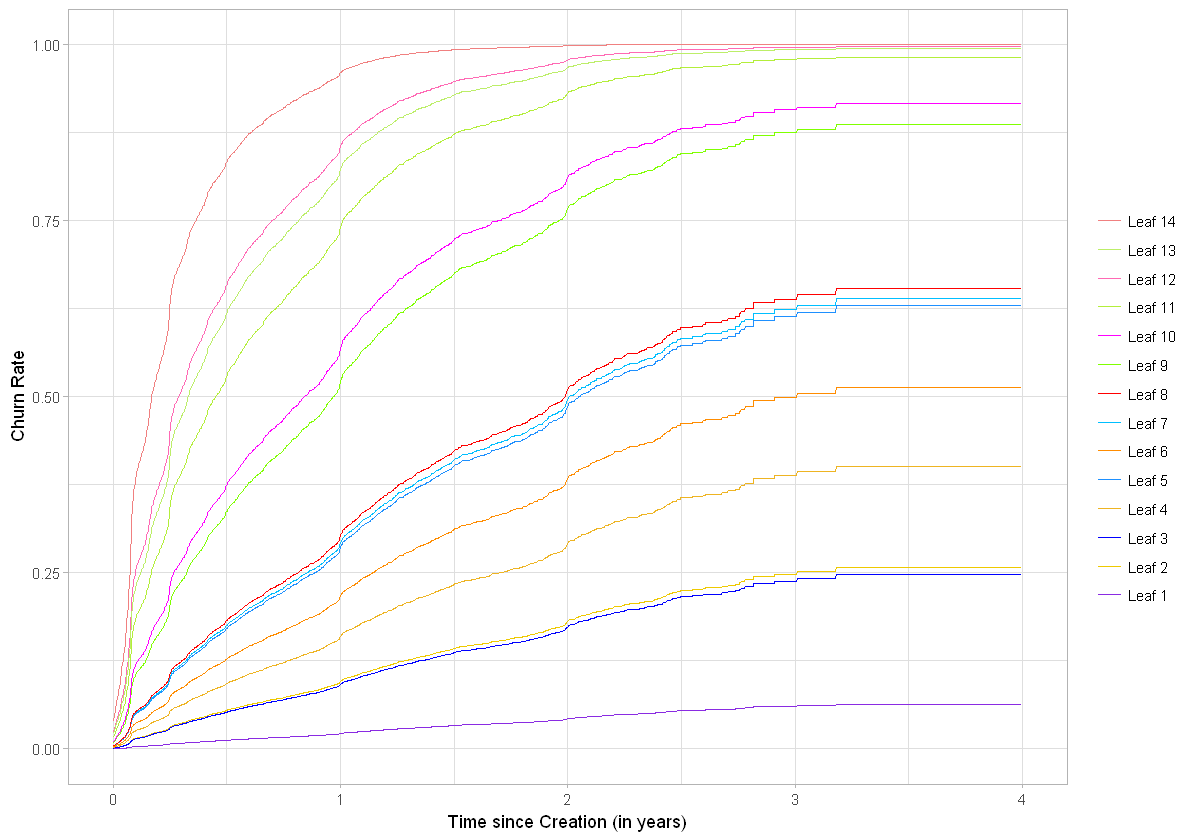

In [39]:
data$where <- factor(fit$where)
pred <- coxph(Surv(time, status == 1) ~ factor(where), data = data)
pred1 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(5)))
pred2 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(6)))
pred3 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(8)))
pred4 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(10)))
pred5 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(11)))
pred6 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(13)))
pred7 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(15)))
pred8 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(17)))
pred9 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(18)))
pred10 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(21)))
pred11 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(22)))
pred12 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(24)))
pred13 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(26)))
pred14 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'where' = factor(27)))

# Plot 
colours <- c('blueviolet', 'gold2', 'blue', 'goldenrod2', 'dodgerblue', 'darkorange', 'deepskyblue', 'red', 'chartreuse', 'magenta', 'olivedrab2', 'hotpink', 'darkolivegreen2', 'lightcoral')
names(colours) <- c('Leaf 1', 'Leaf 2', 'Leaf 3', 'Leaf 4', 'Leaf 5', 'Leaf 6', 'Leaf 7', 'Leaf 8', 'Leaf 9', 'Leaf 10', 'Leaf 11', 'Leaf 12', 'Leaf 13', 'Leaf 14')
ggplot(data = NULL) +
    # For the NAs group
    geom_line(aes(1:1460, 1 - exp(-pred1), colour = 'Leaf 1')) +
    geom_line(aes(1:1460, 1 - exp(-pred2), colour = 'Leaf 2')) +
    geom_line(aes(1:1460, 1 - exp(-pred3), colour = 'Leaf 3')) +
    geom_line(aes(1:1460, 1 - exp(-pred4), colour = 'Leaf 4')) +
    geom_line(aes(1:1460, 1 - exp(-pred5), colour = 'Leaf 5')) +
    geom_line(aes(1:1460, 1 - exp(-pred6), colour = 'Leaf 6')) +
    geom_line(aes(1:1460, 1 - exp(-pred7), colour = 'Leaf 7')) +
    geom_line(aes(1:1460, 1 - exp(-pred8), colour = 'Leaf 8')) +
    geom_line(aes(1:1460, 1 - exp(-pred9), colour = 'Leaf 9')) +
    geom_line(aes(1:1460, 1 - exp(-pred10), colour = 'Leaf 10')) +
    geom_line(aes(1:1460, 1 - exp(-pred11), colour = 'Leaf 11')) +
    geom_line(aes(1:1460, 1 - exp(-pred12), colour = 'Leaf 12')) +
    geom_line(aes(1:1460, 1 - exp(-pred13), colour = 'Leaf 13')) +
    geom_line(aes(1:1460, 1 - exp(-pred14), colour = 'Leaf 14')) +
    
    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours, breaks = rev(names(colours))) +
    theme_light() 

ggsave('img/km_pred.png', height = 4, width = 5)

In [40]:
print(1 - exp(-pred1[365]))
print(1 - exp(-pred2[365]))
print(1 - exp(-pred3[365]))
print(1 - exp(-pred4[365]))
print(1 - exp(-pred5[365]))
print(1 - exp(-pred6[365]))
print(1 - exp(-pred7[365]))
print(1 - exp(-pred8[365]))
print(1 - exp(-pred9[365]))
print(1 - exp(-pred10[365]))
print(1 - exp(-pred11[365]))
print(1 - exp(-pred12[365]))
print(1 - exp(-pred13[365]))
print(1 - exp(-pred14[365]))

[1] 0.02191081
[1] 0.09595632
[1] 0.09182972
[1] 0.159885
[1] 0.285842
[1] 0.2170319
[1] 0.2924733
[1] 0.3026292
[1] 0.5212795
[1] 0.568689
[1] 0.740672
[1] 0.8545413
[1] 0.8222835
[1] 0.9593974


Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_path)."

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_path)."

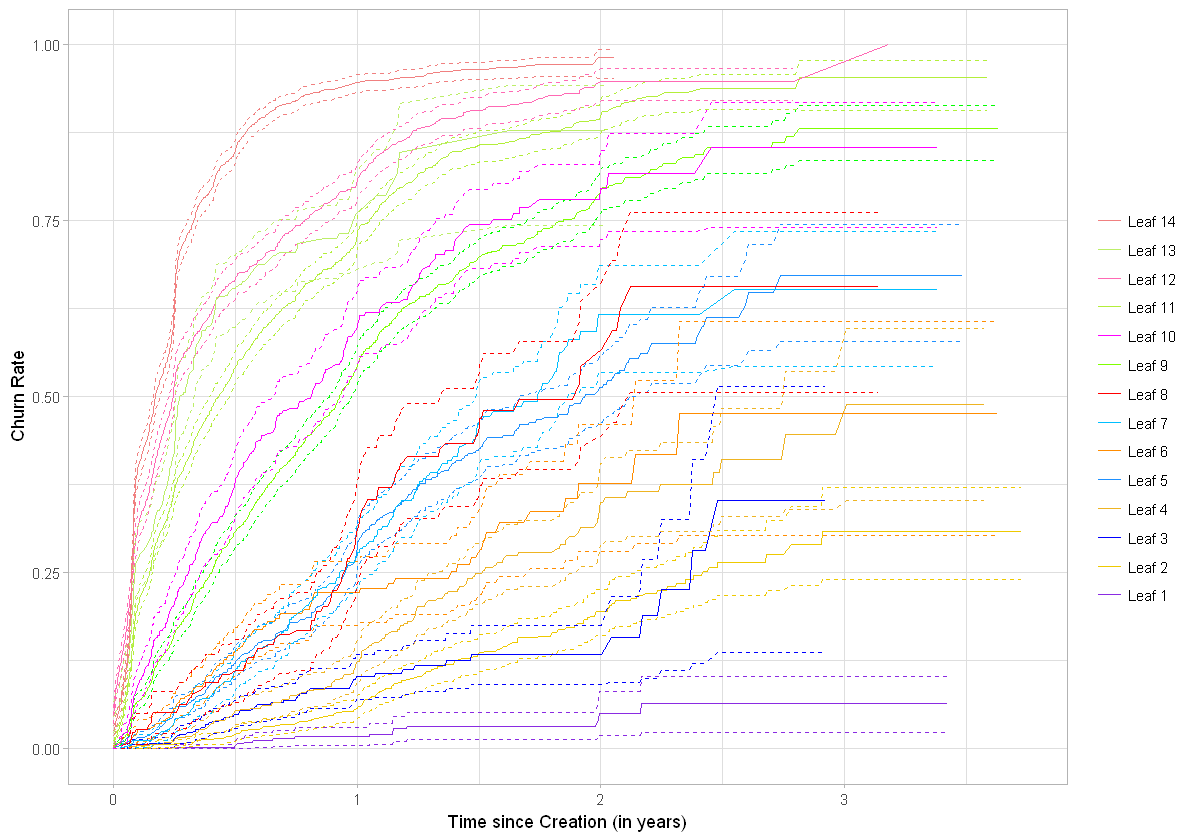

In [41]:
pred <- survfit(Surv(time, status == 1) ~ factor(where), data = data)

ggplot(data = NULL) +
    # 10th leaf
    geom_line(aes(pred$time[1:sum(pred$strata[1])], 1 - pred$lower[1:sum(pred$strata[1])]), 
              lty = 2, colour = 'blueviolet') +
    geom_line(aes(pred$time[1:sum(pred$strata[1])], 1 - pred$upper[1:sum(pred$strata[1])]), 
              lty = 2, colour = 'blueviolet') +
    geom_line(aes(pred$time[1:sum(pred$strata[1])], 1 - pred$surv[1:sum(pred$strata[1])], 
                 colour = 'Leaf 1')) +

    # 9th leaf
    geom_line(aes(pred$time[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 1 - pred$lower[(sum(pred$strata[1])+1):sum(pred$strata[1:2])]), 
              lty = 2, colour = 'gold2') +
    geom_line(aes(pred$time[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 1 - pred$upper[(sum(pred$strata[1])+1):sum(pred$strata[1:2])]), 
              lty = 2, colour = 'gold2') +
    geom_line(aes(pred$time[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 1 - pred$surv[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 
                 colour = 'Leaf 2')) +

    # 8th Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 1 - pred$lower[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 1 - pred$upper[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 1 - pred$surv[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 
                 colour = 'Leaf 3')) +
    
    # 7th Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 1 - pred$lower[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])]), 
              lty = 2, colour = 'goldenrod2') +
    geom_line(aes(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 1 - pred$upper[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])]), 
              lty = 2, colour = 'goldenrod2') +
    geom_line(aes(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 1 - pred$surv[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 
                 colour = 'Leaf 4')) +

    # 6th Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 1 - pred$lower[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])]), 
              lty = 2, colour = 'dodgerblue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 1 - pred$upper[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])]), 
              lty = 2, colour = 'dodgerblue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 1 - pred$surv[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 
                 colour = 'Leaf 5')) +

    # 5th Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:5])+1):sum(pred$strata[1:6])], 1 - pred$lower[(sum(pred$strata[1:5])+1):sum(pred$strata[1:6])]), 
              lty = 2, colour = 'darkorange') +
    geom_line(aes(pred$time[(sum(pred$strata[1:5])+1):sum(pred$strata[1:6])], 1 - pred$upper[(sum(pred$strata[1:5])+1):sum(pred$strata[1:6])]), 
              lty = 2, colour = 'darkorange') +
    geom_line(aes(pred$time[(sum(pred$strata[1:5])+1):sum(pred$strata[1:6])], 1 - pred$surv[(sum(pred$strata[1:5])+1):sum(pred$strata[1:6])], 
                 colour = 'Leaf 6')) +

    # 4th Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:6])+1):sum(pred$strata[1:7])], 1 - pred$lower[(sum(pred$strata[1:6])+1):sum(pred$strata[1:7])]), 
              lty = 2, colour = 'deepskyblue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:6])+1):sum(pred$strata[1:7])], 1 - pred$upper[(sum(pred$strata[1:6])+1):sum(pred$strata[1:7])]), 
              lty = 2, colour = 'deepskyblue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:6])+1):sum(pred$strata[1:7])], 1 - pred$surv[(sum(pred$strata[1:6])+1):sum(pred$strata[1:7])], 
                 colour = 'Leaf 7')) +

    # 3rd Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:7])+1):sum(pred$strata[1:8])], 1 - pred$lower[(sum(pred$strata[1:7])+1):sum(pred$strata[1:8])]), 
              lty = 2, colour = 'red') +
    geom_line(aes(pred$time[(sum(pred$strata[1:7])+1):sum(pred$strata[1:8])], 1 - pred$upper[(sum(pred$strata[1:7])+1):sum(pred$strata[1:8])]), 
              lty = 2, colour = 'red') +
    geom_line(aes(pred$time[(sum(pred$strata[1:7])+1):sum(pred$strata[1:8])], 1 - pred$surv[(sum(pred$strata[1:7])+1):sum(pred$strata[1:8])], 
                 colour = 'Leaf 8')) +

    # 2nd Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:8])+1):sum(pred$strata[1:9])], 1 - pred$lower[(sum(pred$strata[1:8])+1):sum(pred$strata[1:9])]), 
              lty = 2, colour = 'green') +
    geom_line(aes(pred$time[(sum(pred$strata[1:8])+1):sum(pred$strata[1:9])], 1 - pred$upper[(sum(pred$strata[1:8])+1):sum(pred$strata[1:9])]), 
              lty = 2, colour = 'green') +
    geom_line(aes(pred$time[(sum(pred$strata[1:8])+1):sum(pred$strata[1:9])], 1 - pred$surv[(sum(pred$strata[1:8])+1):sum(pred$strata[1:9])], 
                 colour = 'Leaf 9')) +

    # 1st Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:9])+1):sum(pred$strata[1:10])], 1 - pred$lower[(sum(pred$strata[1:9])+1):sum(pred$strata[1:10])]), 
              lty = 2, colour = 'magenta') +
    geom_line(aes(pred$time[(sum(pred$strata[1:9])+1):sum(pred$strata[1:10])], 1 - pred$upper[(sum(pred$strata[1:9])+1):sum(pred$strata[1:10])]), 
              lty = 2, colour = 'magenta') +
    geom_line(aes(pred$time[(sum(pred$strata[1:9])+1):sum(pred$strata[1:10])], 1 - pred$surv[(sum(pred$strata[1:9])+1):sum(pred$strata[1:10])], 
                 colour = 'Leaf 10')) +
    
    # 1st Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:10])+1):sum(pred$strata[1:11])], 1 - pred$lower[(sum(pred$strata[1:10])+1):sum(pred$strata[1:11])]), 
              lty = 2, colour = 'olivedrab2') +
    geom_line(aes(pred$time[(sum(pred$strata[1:10])+1):sum(pred$strata[1:11])], 1 - pred$upper[(sum(pred$strata[1:10])+1):sum(pred$strata[1:11])]), 
              lty = 2, colour = 'olivedrab2') +
    geom_line(aes(pred$time[(sum(pred$strata[1:10])+1):sum(pred$strata[1:11])], 1 - pred$surv[(sum(pred$strata[1:10])+1):sum(pred$strata[1:11])], 
                 colour = 'Leaf 11')) +

    # 1st Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:11])+1):sum(pred$strata[1:12])], 1 - pred$lower[(sum(pred$strata[1:11])+1):sum(pred$strata[1:12])]), 
              lty = 2, colour = 'hotpink') +
    geom_line(aes(pred$time[(sum(pred$strata[1:11])+1):sum(pred$strata[1:12])], 1 - pred$upper[(sum(pred$strata[1:11])+1):sum(pred$strata[1:12])]), 
              lty = 2, colour = 'hotpink') +
    geom_line(aes(pred$time[(sum(pred$strata[1:11])+1):sum(pred$strata[1:12])], 1 - pred$surv[(sum(pred$strata[1:11])+1):sum(pred$strata[1:12])], 
                 colour = 'Leaf 12')) +

    # 1st Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:12])+1):sum(pred$strata[1:13])], 1 - pred$lower[(sum(pred$strata[1:12])+1):sum(pred$strata[1:13])]), 
              lty = 2, colour = 'darkolivegreen2') +
    geom_line(aes(pred$time[(sum(pred$strata[1:12])+1):sum(pred$strata[1:13])], 1 - pred$upper[(sum(pred$strata[1:12])+1):sum(pred$strata[1:13])]), 
              lty = 2, colour = 'darkolivegreen2') +
    geom_line(aes(pred$time[(sum(pred$strata[1:12])+1):sum(pred$strata[1:13])], 1 - pred$surv[(sum(pred$strata[1:12])+1):sum(pred$strata[1:13])], 
                 colour = 'Leaf 13')) +

    # 1st Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:13])+1):sum(pred$strata[1:14])], 1 - pred$lower[(sum(pred$strata[1:13])+1):sum(pred$strata[1:14])]), 
              lty = 2, colour = 'lightcoral') +
    geom_line(aes(pred$time[(sum(pred$strata[1:13])+1):sum(pred$strata[1:14])], 1 - pred$upper[(sum(pred$strata[1:13])+1):sum(pred$strata[1:14])]), 
              lty = 2, colour = 'lightcoral') +
    geom_line(aes(pred$time[(sum(pred$strata[1:13])+1):sum(pred$strata[1:14])], 1 - pred$surv[(sum(pred$strata[1:13])+1):sum(pred$strata[1:14])], 
                 colour = 'Leaf 14')) +

    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours, breaks = rev(names(colours))) +
    theme_light()

ggsave('img/km_estim.png', height = 4, width = 5)

In [42]:
print(1 - pred$surv[min(which(pred$time >= 365))])
print(1 - pred$surv[pred$strata[1] + min(which(pred$time[(pred$strata[1]+1):sum(pred$strata[1:2])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:2]) + min(which(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:3]) + min(which(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:4]) + min(which(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:5]) + min(which(pred$time[(sum(pred$strata[1:5])+1):sum(pred$strata[1:6])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:6]) + min(which(pred$time[(sum(pred$strata[1:6])+1):sum(pred$strata[1:7])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:7]) + min(which(pred$time[(sum(pred$strata[1:7])+1):sum(pred$strata[1:8])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:8]) + min(which(pred$time[(sum(pred$strata[1:8])+1):sum(pred$strata[1:9])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:9]) + min(which(pred$time[(sum(pred$strata[1:9])+1):sum(pred$strata[1:10])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:10]) + min(which(pred$time[(sum(pred$strata[1:10])+1):sum(pred$strata[1:11])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:11]) + min(which(pred$time[(sum(pred$strata[1:11])+1):sum(pred$strata[1:12])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:12]) + min(which(pred$time[(sum(pred$strata[1:12])+1):sum(pred$strata[1:13])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:13]) + min(which(pred$time[(sum(pred$strata[1:13])+1):sum(pred$strata[1:14])] >= 365))])

[1] 0.01775549
[1] 0.05793649
[1] 0.1023262
[1] 0.1244269
[1] 0.290004
[1] 0.2220432
[1] 0.274962
[1] 0.3155727
[1] 0.5439975
[1] 0.598304
[1] 0.7323386
[1] 0.8060841
[1] 0.7854314
[1] 0.9454353


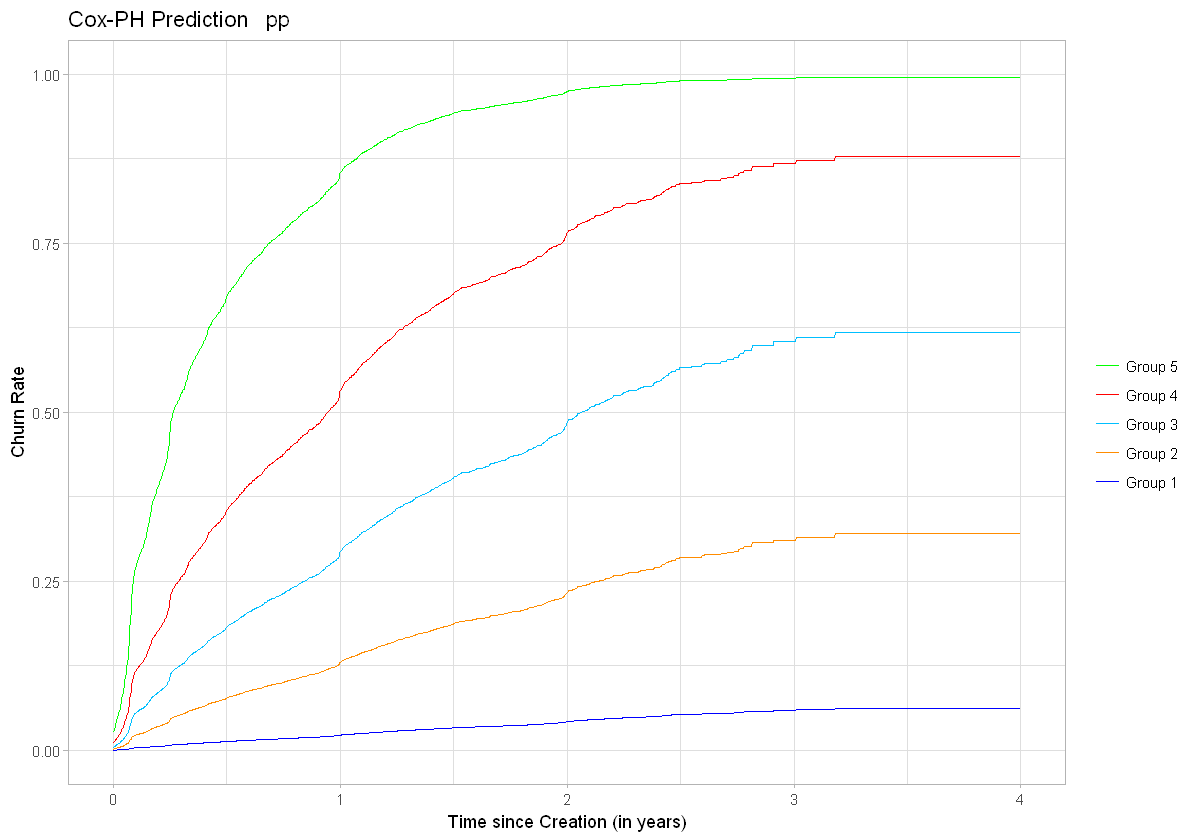

In [47]:
data$group <- 1
data$group[data$where == 6] <- 2
data$group[data$where == 8] <- 2
data$group[data$where == 10] <- 2
data$group[data$where == 11] <- 4
data$group[data$where == 13] <- 2
data$group[data$where == 15] <- 4
data$group[data$where == 17] <- 4
data$group[data$where == 18] <- 5
data$group[data$where == 21] <- 5
data$group[data$where == 22] <- 6
data$group[data$where == 24] <- 6
data$group[data$where == 26] <- 6
data$group[data$where == 27] <- 6
data$group <- as.factor(data$group)

pred <- coxph(Surv(time, status == 1) ~ group, data = data)
pred1 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'group' = factor(1)))
pred2 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'group' = factor(2)))
pred4 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'group' = factor(4)))
pred5 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'group' = factor(5)))
pred6 <- predict(pred, type = 'expected', newdata = data_frame(
    'time' = 1:(4*365),
    'status' = 1,
    'group' = factor(6)))

# Plot 
colours <- c('green', 'red', 'deepskyblue', 'darkorange', 'blue')
names(colours) <- c('Group 5', 'Group 4', 'Group 3', 'Group 2', 'Group 1')
ggplot(data = NULL) +
    # For the NAs group
    geom_line(aes(1:1460, 1 - exp(-pred1), colour = 'Group 1')) +
    geom_line(aes(1:1460, 1 - exp(-pred2), colour = 'Group 2')) +
    geom_line(aes(1:1460, 1 - exp(-pred4), colour = 'Group 3')) +
    geom_line(aes(1:1460, 1 - exp(-pred5), colour = 'Group 4')) +
    geom_line(aes(1:1460, 1 - exp(-pred6), colour = 'Group 5')) +
    
    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours, breaks = names(colours)) +
    ggtitle("Cox-PH Prediction   pp") + theme_light() 

ggsave('img/km_pred2.png', height = 4, width = 5)

In [48]:
print(1 - exp(-pred1[365]))
print(1 - exp(-pred2[365]))
print(1 - exp(-pred4[365]))
print(1 - exp(-pred5[365]))
print(1 - exp(-pred6[365]))

[1] 0.02239063
[1] 0.1294511
[1] 0.2919674
[1] 0.5290553
[1] 0.851538


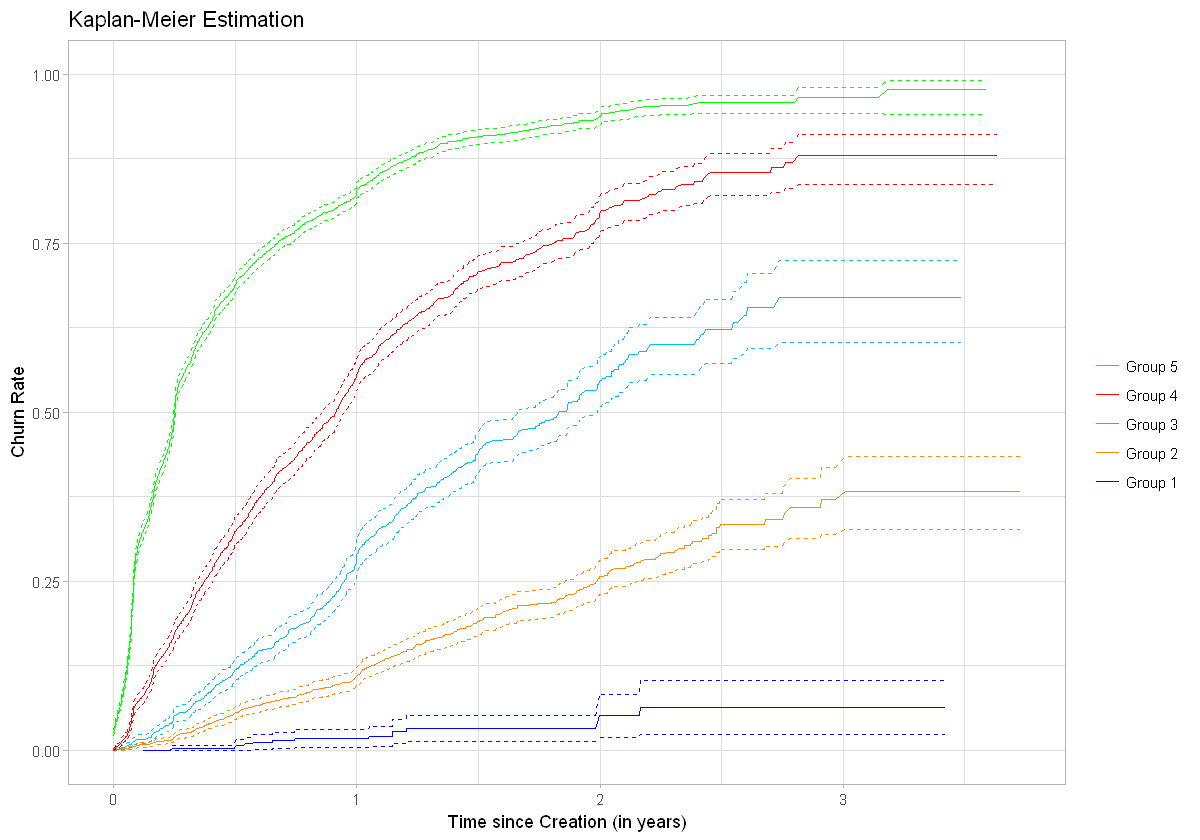

In [49]:
pred <- survfit(Surv(time, status == 1) ~ group, data = data)

ggplot(data = NULL) +
    # 10th leaf
    geom_line(aes(pred$time[1:sum(pred$strata[1])], 1 - pred$lower[1:sum(pred$strata[1])]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(pred$time[1:sum(pred$strata[1])], 1 - pred$upper[1:sum(pred$strata[1])]), 
              lty = 2, colour = 'blue') +
    geom_line(aes(pred$time[1:sum(pred$strata[1])], 1 - pred$surv[1:sum(pred$strata[1])], 
                 colour = 'Group 1')) +

    # 9th leaf
    geom_line(aes(pred$time[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 1 - pred$lower[(sum(pred$strata[1])+1):sum(pred$strata[1:2])]), 
              lty = 2, colour = 'darkorange') +
    geom_line(aes(pred$time[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 1 - pred$upper[(sum(pred$strata[1])+1):sum(pred$strata[1:2])]), 
              lty = 2, colour = 'darkorange') +
    geom_line(aes(pred$time[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 1 - pred$surv[(sum(pred$strata[1])+1):sum(pred$strata[1:2])], 
                 colour = 'Group 2')) +

    # 8th Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 1 - pred$lower[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])]), 
              lty = 2, colour = 'deepskyblue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 1 - pred$upper[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])]), 
              lty = 2, colour = 'deepskyblue') +
    geom_line(aes(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 1 - pred$surv[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])], 
                 colour = 'Group 3')) +
    
    # 7th Leaf
    geom_line(aes(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 1 - pred$lower[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])]), 
              lty = 2, colour = 'red') +
    geom_line(aes(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 1 - pred$upper[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])]), 
              lty = 2, colour = 'red') +
    geom_line(aes(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 1 - pred$surv[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])], 
                 colour = 'Group 4')) +

    geom_line(aes(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 1 - pred$lower[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])]), 
              lty = 2, colour = 'green') +
    geom_line(aes(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 1 - pred$upper[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])]), 
              lty = 2, colour = 'green') +
    geom_line(aes(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 1 - pred$surv[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])], 
                 colour = 'Group 5')) +
    
    scale_x_continuous("Time since Creation (in years)", breaks = c(0, 365.25, 730.5, 1095.75, 1461, 1826.25), 
                       labels = c('0', '1', '2', '3', '4', '5')) + 
    ylab("Churn Rate") + ylim(c(0, 1)) +
    scale_colour_manual("", values = colours, breaks = names(colours)) +
    ggtitle("Kaplan-Meier Estimation") + theme_light()

ggsave('img/km_estim2.png', height = 4, width = 5)

In [50]:
print(1 - pred$surv[min(which(pred$time >= 365))])
print(1 - pred$surv[pred$strata[1] + min(which(pred$time[(pred$strata[1]+1):sum(pred$strata[1:2])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:2]) + min(which(pred$time[(sum(pred$strata[1:2])+1):sum(pred$strata[1:3])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:3]) + min(which(pred$time[(sum(pred$strata[1:3])+1):sum(pred$strata[1:4])] >= 365))])
print(1 - pred$surv[sum(pred$strata[1:4]) + min(which(pred$time[(sum(pred$strata[1:4])+1):sum(pred$strata[1:5])] >= 365))])

[1] 0.01775549
[1] 0.1104716
[1] 0.2878659
[1] 0.5549086
[1] 0.8268633
